### Library

In [1]:
import cv2
import PIL
import matplotlib.pyplot as plt
import os
import glob
import torch
import numpy as np
import torchvision
import time
import pandas as pd
import seaborn as sns
import warnings
import sys
warnings.filterwarnings("ignore")
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import  plot_model ,Sequence
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

In [2]:
# Colab GPU A100 High Memory: VRAM 80GB
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [3]:
# Colab root
# dataset_root = "/content/drive/MyDrive/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"

# Local root
dataset_root = "/Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"
records = []
image_class = ["stain", "scratch", "oil"] # good 제외

for class_name in image_class:
    class_path = os.path.join(dataset_root, class_name)

    if not os.path.isdir(class_path):
        continue

    for file in tqdm(os.listdir(class_path)):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(class_path, file)

            img = cv2.imread(img_path)
            if img is None:
                continue

            h, w, c = img.shape

            # 클래스별로 마스크 찾기
            mask_path = None
            mask_name = file.replace('.jpg', '.png')

            if class_name == "stain":
                # Sta_0001.jpg -> Sta_0001.png (ground_truth_1)
                potential_mask = os.path.join(dataset_root, "ground_truth_1", mask_name)
                if os.path.exists(potential_mask):
                    mask_path = potential_mask
            elif class_name == "scratch":
                # Scr_0001.jpg -> Scr_0001.png (ground_truth_1)
                potential_mask = os.path.join(dataset_root, "ground_truth_1", mask_name)
                if os.path.exists(potential_mask):
                    mask_path = potential_mask
            elif class_name == "oil":
                # Oil_0001.jpg -> Oil_0001.png (ground_truth_2)
                potential_mask = os.path.join(dataset_root, "ground_truth_2", mask_name)
                if os.path.exists(potential_mask):
                    mask_path = potential_mask

            records.append({
                "class": class_name,
                "file_name": file,
                "image_path": img_path,
                "mask_path": mask_path,
                "height": h,
                "width": w,
                "channels": c,
            })

df = pd.DataFrame(records)
df

100%|██████████| 400/400 [00:09<00:00, 41.49it/s]


,class,file_name,image_path,mask_path,height,width,channels
0,stain,Sta_0087.jpg,/Users/mungughyeon/Library/CloudStorage/Google...,/Users/mungughyeon/Library/CloudStorage/Google...,1080,1920,3
1,stain,Sta_0093.jpg,/Users/mungughyeon/Library/CloudStorage/Google...,/Users/mungughyeon/Library/CloudStorage/Google...,1080,1920,3
2,stain,Sta_0078.jpg,/Users/mungughyeon/Library/CloudStorage/Google...,/Users/mungughyeon/Library/CloudStorage/Google...,1080,1920,3
3,stain,Sta_0044.jpg,/Users/mungughyeon/Library/CloudStorage/Google...,/Users/mungughyeon/Library/CloudStorage/Google...,1080,1920,3
4,stain,Sta_0050.jpg,/Users/mungughyeon/Library/CloudStorage/Google...,/Users/mungughyeon/Library/CloudStorage/Google...,1080,1920,3
...,...,...,...,...,...,...,...
1195,oil,Oil_0082.jpg,/Users/mungughyeon/Library/CloudStorage/Google...,/Users/mungughyeon/Library/CloudStorage/Google...,1080,1920,3
1196,oil,Oil_0257.jpg,/Users/mungughyeon/Library/CloudStorage/Google...,/Users/mungughyeon/Library/CloudStorage/Google...,1080,1920,3
1197,oil,Oil_0243.jpg,/Users/mungughyeon/Library/CloudStorage/Google...,/Users/mungughyeon/Library/CloudStorage/Google...,1080,1920,3
1198,oil,Oil_0294.jpg,/Users/mungughyeon/Library/CloudStorage/Google...,/Users/mungughyeon/Library/CloudStorage/Google...,1080,1920,3


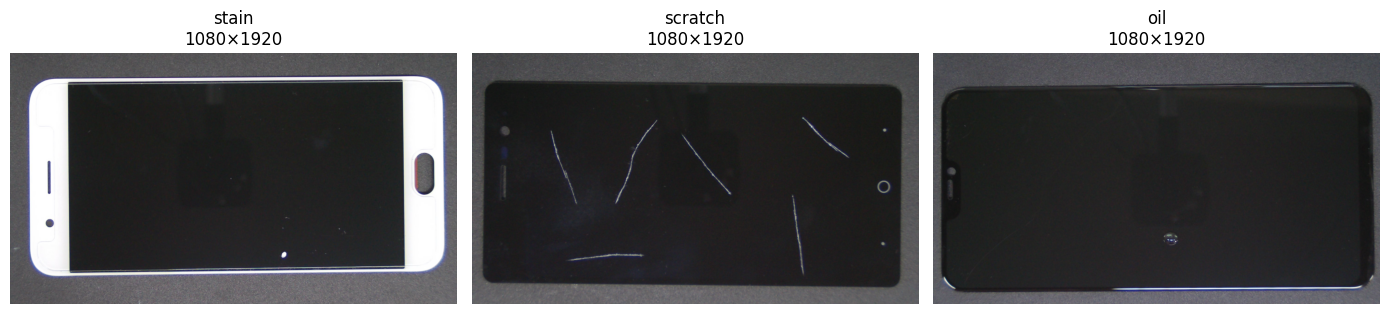

In [4]:
plt.figure(figsize=(14, 6))

classes = df["class"].unique()

for idx, cls in enumerate(classes):
    sample_row = df[df["class"] == cls].sample(1, random_state=42).iloc[0]

    img = cv2.imread(sample_row["image_path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape

    plt.subplot(1, len(classes), idx + 1)
    plt.imshow(img)
    plt.title(f"{cls}\n{h}×{w}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Import Custom Modules

In [5]:
sys.path.append("../")
from src.segtool.config import DataConfig, TrainConfig
from src.segtool.data import (
    make_loaders,
    DefectSegDataset,
    DatasetPaths,
    default_paths,
    find_mask
)
from src.segtool.model import FCN, UNet, DoubleConv
from src.segtool.models_factory import build_model
from src.segtool.losses import BCEDiceLoss, DiceLoss
from src.segtool.engine import (
    train_one_epoch,
    validate,
    EpochResult,
    _defect_only_metrics
)
from src.segtool.metrics import compute_metrics, reduce_mean, Metrics
from src.segtool.utils import *

set_seed(42)
device = get_device()
print(device)

mps


### Data Load

In [6]:
base_path = Path(dataset_root)
train_loader, val_loader, test_loader = make_loaders(
    base_path=base_path,
    img_size_hw=(144, 256),  # (height, width)
    train_ratio=0.7,
    test_ratio=0.15,
    seed=42,
    batch_size=4, # mps: 4
    num_workers=2
)

print(f"Train: {len(train_loader.dataset)}")
print(f"Val: {len(val_loader.dataset)}")
print(f"Test: {len(test_loader.dataset)}")

Train: 840
Val: 180
Test: 180


### Model Load

In [7]:
fcn_model = FCN(
    in_channels=3,
    out_channels=1,
    base_channels=32,
    dropout=0.1
).to(device)

total_params = sum(p.numel() for p in fcn_model.parameters())
trainable_params = sum(p.numel() for p in fcn_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 332,257
Trainable parameters: 332,257


In [8]:
# optimizer
optimizer = torch.optim.Adam(
    fcn_model.parameters(),
    lr=1e-3,
    weight_decay=0.0
)

# loss function
criterion = BCEDiceLoss(bce_weight=0.5)  # BCE와 Dice Loss 조합

print(f"Device: {device}")
print(f"Model: {fcn_model.__class__.__name__}")
print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Dropout: {getattr(fcn_model.dropout, 'p', 0.0)}")

Device: mps
Model: FCN
Loss function: BCEDiceLoss
Optimizer: Adam
Batch size: 4
Learning rate: 0.001
Dropout: 0.1


### Training Loop

In [9]:
train_losses = []
val_losses = []
train_dices = []
val_dices = []
val_defect_dices = []

epochs = 10
best_val_dice = -1.0
threshold = 0.5

print(f"Starting Training for {epochs} epochs")
print("=" * 60)

# loop
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    # Training
    train_result = train_one_epoch(
        model=fcn_model,
        loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # Validation
    val_result = validate(
        model=fcn_model,
        loader=val_loader,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # 기록 저장
    train_losses.append(train_result.loss)
    val_losses.append(val_result.loss)
    train_dices.append(train_result.metrics_all.dice)
    val_dices.append(val_result.metrics_all.dice) # 모든 샘플에 대해 계산 (정상 포함)
    val_defect_dices.append(val_result.metrics_defect_only.dice) # 결함이 있는 샘플만 계산

    # result
    print(f"Train - Loss: {train_result.loss:.4f} | Dice: {train_result.metrics_all.dice:.4f}")
    print(f"Val - Loss: {val_result.loss:.4f} | Dice: {val_result.metrics_all.dice:.4f} | Defect Dice: {val_result.metrics_defect_only.dice:.4f}")
    print("-" * 60)

    if val_result.metrics_defect_only.dice > best_val_dice:
        best_val_dice = val_result.metrics_defect_only.dice

print("\nTraining completed!")
print(f"Best Validation Defect Dice: {best_val_dice:.4f}")

Starting Training for 10 epochs
Epoch 1/10
Train - Loss: 0.5329 | Dice: 0.0003
Val - Loss: 0.5075 | Dice: 0.0000 | Defect Dice: 0.0000
------------------------------------------------------------
Epoch 2/10
Train - Loss: 0.3005 | Dice: 0.4509
Val - Loss: 0.2536 | Dice: 0.5469 | Defect Dice: 0.5626
------------------------------------------------------------
Epoch 3/10
Train - Loss: 0.2085 | Dice: 0.6372
Val - Loss: 0.2172 | Dice: 0.6156 | Defect Dice: 0.6264
------------------------------------------------------------
Epoch 4/10
Train - Loss: 0.1751 | Dice: 0.6956
Val - Loss: 0.1630 | Dice: 0.7160 | Defect Dice: 0.7206
------------------------------------------------------------
Epoch 5/10
Train - Loss: 0.1481 | Dice: 0.7475
Val - Loss: 0.1383 | Dice: 0.7689 | Defect Dice: 0.7714
------------------------------------------------------------
Epoch 6/10
Train - Loss: 0.1235 | Dice: 0.7933
Val - Loss: 0.1200 | Dice: 0.7985 | Defect Dice: 0.8020
---------------------------------------------

In [16]:
def plot_training_history(train_losses, val_losses, train_dices, val_dices, val_defect_dices, 
                        save_path=None, figsize=(16, 6)):
    plt.figure(figsize=figsize)
    epochs = range(1, len(train_losses) + 1)
    best_val_dice = max(val_defect_dices)
    best_epoch = val_defect_dices.index(best_val_dice) + 1

    # 1. Loss curves
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Dice Score curves (All samples)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_dices, 'b-', label='Train Dice', linewidth=2)
    plt.plot(epochs, val_dices, 'r-', label='Val Dice', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Dice Score (All Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Defect-only Dice Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_defect_dices, 'g-', label='Val Dice (Defect)', linewidth=2)
    plt.axhline(y=best_val_dice, color='orange', linestyle='--',
                label=f'Best: {best_val_dice:.4f}')
    plt.axvline(x=best_epoch, color='orange', linestyle=':', alpha=0.7,
                label=f'Best Epoch: {best_epoch}')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Defect-Only Dice Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()

    # Print summary
    print_training_summary(train_losses, val_losses, val_dices, val_defect_dices)

def print_training_summary(train_losses, val_losses, val_dices, val_defect_dices):
    """Print training summary statistics"""
    best_val_dice = max(val_defect_dices)
    best_epoch = val_defect_dices.index(best_val_dice) + 1

    print(f"TRAINING SUMMARY")
    print(f"{'='*50}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Val Loss: {val_losses[-1]:.4f}")
    print(f"Final Val Dice (All): {val_dices[-1]:.4f}")
    print(f"Final Val Dice (Defect): {val_defect_dices[-1]:.4f}")
    print(f"Best Val Dice (Defect): {best_val_dice:.4f}")
    print(f"Best Epoch: {best_epoch}")

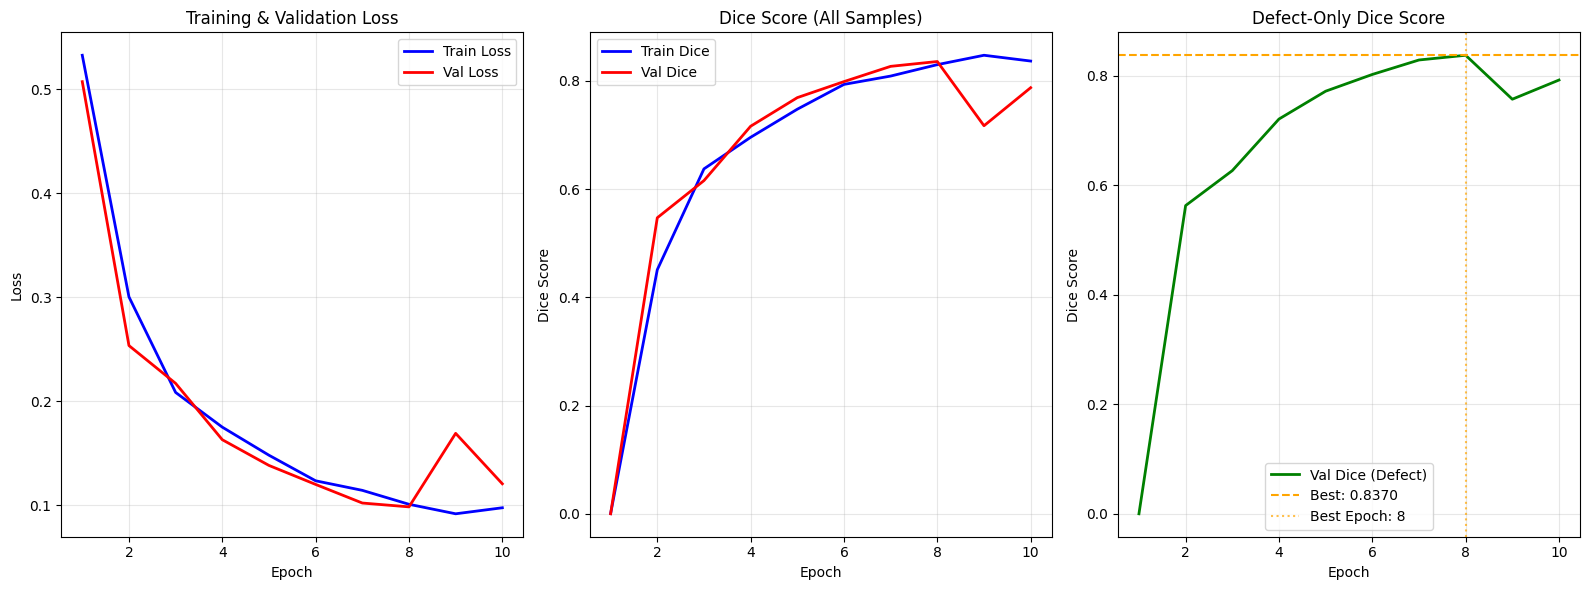

TRAINING SUMMARY
Final Train Loss: 0.0976
Final Val Loss: 0.1206
Final Val Dice (All): 0.7872
Final Val Dice (Defect): 0.7918
Best Val Dice (Defect): 0.8370
Best Epoch: 8


In [17]:
plot_training_history(train_losses, val_losses, train_dices, val_dices, val_defect_dices)

### Inference

In [25]:
def inference_test_set(model, test_loader, criterion, device, threshold=0.5):
    """Inference model on test set"""
    print("Evaluating on Test Set...")
    print("-" * 40)

    test_result = validate(
        model=model,
        loader=test_loader,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    print("TEST RESULTS")
    print("=" * 40)
    print(f"Test Loss: {test_result.loss:.4f}")
    print(f"Test Dice (All): {test_result.metrics_all.dice:.4f}")
    print(f"Test IoU (All): {test_result.metrics_all.iou:.4f}")
    print(f"Test Precision (All): {test_result.metrics_all.precision:.4f}")
    print(f"Test Recall (All): {test_result.metrics_all.recall:.4f}")
    print()
    print("DEFECT-ONLY METRICS")
    print("-" * 30)
    print(f"Test Dice (Defects): {test_result.metrics_defect_only.dice:.4f}")
    print(f"Test IoU (Defects): {test_result.metrics_defect_only.iou:.4f}")
    print(f"Test Precision (Defects): {test_result.metrics_defect_only.precision:.4f}")
    print(f"Test Recall (Defects): {test_result.metrics_defect_only.recall:.4f}")

    return test_result

def inference_visualize(model, test_loader, device, threshold=0.5, num_samples=8):
    """Model inference and visualization"""
    model.eval()

    # Get random samples from test set
    samples = []
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if len(samples) >= num_samples:
                break

            # Unpack 4 items: (images, masks, class_names, file_names)
            images, masks = batch[0], batch[1]
            images = images.to(device)
            masks = masks.to(device)

            # Model prediction
            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold

            # Convert to numpy for visualization
            for j in range(images.size(0)):
                if len(samples) >= num_samples:
                    break

                img = images[j].cpu().permute(1, 2, 0).numpy()
                true_mask = masks[j].cpu().squeeze().numpy()
                pred_mask = preds[j].cpu().squeeze().numpy()
                prob_map = torch.sigmoid(outputs[j]).cpu().squeeze().numpy()

                samples.append({
                    'image': img,
                    'true_mask': true_mask,
                    'pred_mask': pred_mask,
                    'prob_map': prob_map
                })

    # Visualization
    fig, axes = plt.subplots(4, num_samples, figsize=(3*num_samples, 12))

    for i, sample in enumerate(samples):
        # Original image
        axes[0, i].imshow(sample['image'])
        axes[0, i].set_title(f'Sample {i+1}')
        axes[0, i].axis('off')

        # Ground truth mask
        axes[1, i].imshow(sample['true_mask'], cmap='gray')
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')

        # Prediction probability map
        axes[2, i].imshow(sample['prob_map'], cmap='hot', vmin=0, vmax=1)
        axes[2, i].set_title('Probability Map')
        axes[2, i].axis('off')

        # Binary prediction
        axes[3, i].imshow(sample['pred_mask'], cmap='gray')
        axes[3, i].set_title(f'Prediction (>{threshold})')
        axes[3, i].axis('off')

    plt.tight_layout()
    plt.show()

    return samples

Evaluating on Test Set...
----------------------------------------
TEST RESULTS
Test Loss: 0.1078
Test Dice (All): 0.8143
Test IoU (All): 0.6988
Test Precision (All): 0.7645
Test Recall (All): 0.9006

DEFECT-ONLY METRICS
------------------------------
Test Dice (Defects): 0.7776
Test IoU (Defects): 0.6572
Test Precision (Defects): 0.7014
Test Recall (Defects): 0.9262


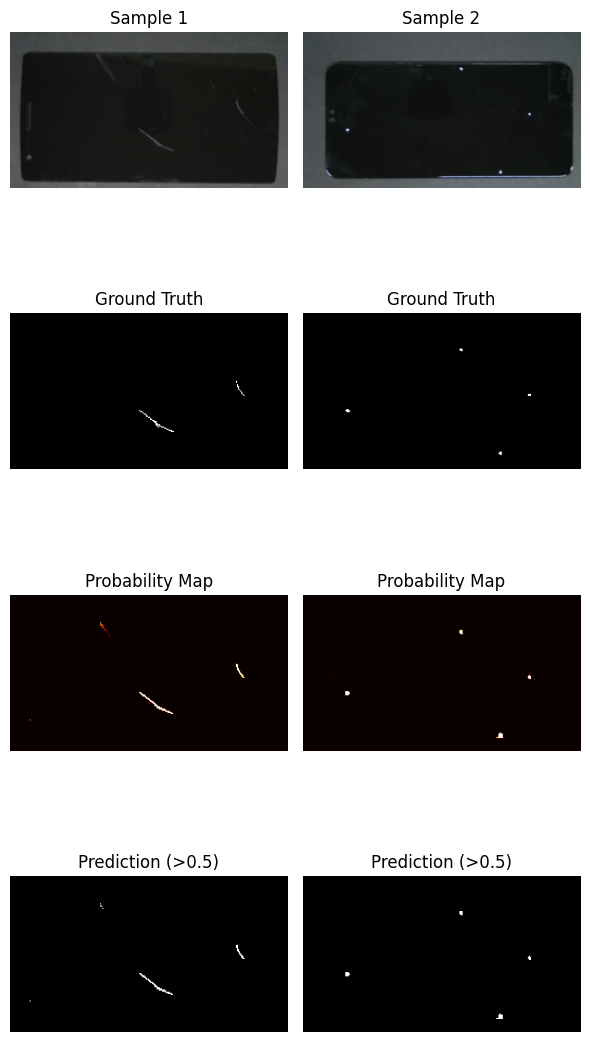

In [26]:
test_result = inference_test_set(fcn_model, test_loader, criterion, device, threshold=0.5)
samples = inference_visualize(fcn_model, test_loader, device, threshold=0.5, num_samples=2)